In [1]:
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# Script to run and export ISSM inversion
# Mikayla Pascual 07/13/22
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#import 
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
from os.path import exists

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

In [2]:
# Load some mat files to use later
vel_mat = loadmat('Cheat_matfiles/vel.mat')
hmaxVertices_mat = loadmat('Cheat_matfiles/hmaxVertices.mat')
param_mat = loadmat('Cheat_matfiles/param.mat')

velx = vel_mat['velx']
vely = vel_mat['vely']
vel = vel_mat['vel']

hmaxVertices = hmaxVertices_mat['hmaxVertices']


In [3]:
# Setup
region = 'SAtoES';
start_year = 1985;

# Mesh sizing
triangleresolution = 1000;
hmin = 300;
hmax = 10000;

# Mesh
md = model()
md = triangle(md,'./Exp/' +region+ '.exp',triangleresolution) # set up mesh

md = bamg(md,'hmin',hmin,'hmax',hmax,'field',vel,'err',2,'hmaxVertices',hmaxVertices);

#savevars('./Models/' +region+ '_mesh', 'md', md)

# 

Anisotropic mesh adaptation

   new number of triangles = 24063


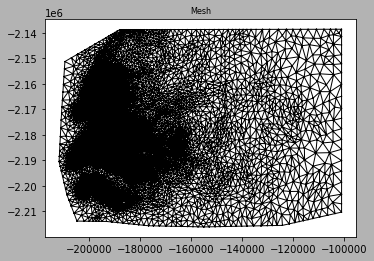

In [4]:
# Plot mesh
plotmodel(md,'data','mesh')

In [5]:
# Load parameters
md.geometry.bed = param_mat['geometry_bed']
md.geometry.surface = param_mat['geometry_surface']
md.geometry.base = param_mat['geometry_base']
md.mask.ice_levelset = param_mat['mask_ice_levelset']
md.mask.groundedice_levelset = param_mat['mask_groundedice_levelset']
md.inversion.vx_obs = param_mat['inversion_vx_obs']
md.inversion.vy_obs = param_mat['inversion_vy_obs']
md.inversion.vel_obs = param_mat['inversion_vel_obs']
md.initialization.vx = param_mat['initialization_vx']
md.initialization.vy = param_mat['initialization_vy']
md.initialization.vz = param_mat['initialization_vz']
md.initialization.vel = param_mat['initialization_vel']
md.friction.coefficient = param_mat['friction_coefficient']
md.materials.rheology_n = param_mat['rheology_n']
md.materials.rheology_B = param_mat['rheology_B']
md.basalforcings.groundedice_melting_rate = param_mat['basalforcings_groundedice_melting_rate']
md.basalforcings.floatingice_melting_rate = param_mat['basalforcings_floatingice_melting_rate']
md.smb.mass_balance = param_mat['smb_mass_balance']
md.basalforcings.geothermalflux = param_mat['basalforcings_geothermalflux']
md.stressbalance.spcvx = param_mat['stressbalance_spcvx']
md.stressbalance.spcvy = param_mat['stressbalance_spcvy']
md.stressbalance.spcvz = param_mat['stressbalance_spcvz']
md.stressbalance.referential = param_mat['stressbalance_referential']
md.stressbalance.loadingforce = param_mat['stressbalance_loadingforce']
md.masstransport.spcthickness = param_mat['masstransport_spcthickness']

# Set bed = base for grounded ice
md.geometry.base = md.geometry.bed
md.geometry.thickness = md.geometry.surface - md.geometry.base

md.friction.q = np.ones(md.mesh.numberofelements)
md.friction.p = np.ones(md.mesh.numberofelements)

md.flowequation.isSSA = 1
md.flowequation.vertex_equation = 2 * np.ones(md.mesh.numberofvertices)
md.flowequation.element_equation = 2 * np.ones(md.mesh.numberofelements)
md.flowequation.borderSSA = np.ones(md.mesh.numberofvertices)
md.flowequation.borderHO = np.ones(md.mesh.numberofvertices)
md.flowequation.borderFS = np.ones(md.mesh.numberofvertices)

md.mask.ocean_levelset = -md.mask.ice_levelset

from generic import generic
md.cluster = generic() #telling where to run issm

md.miscellaneous.name = 'SAtoES'

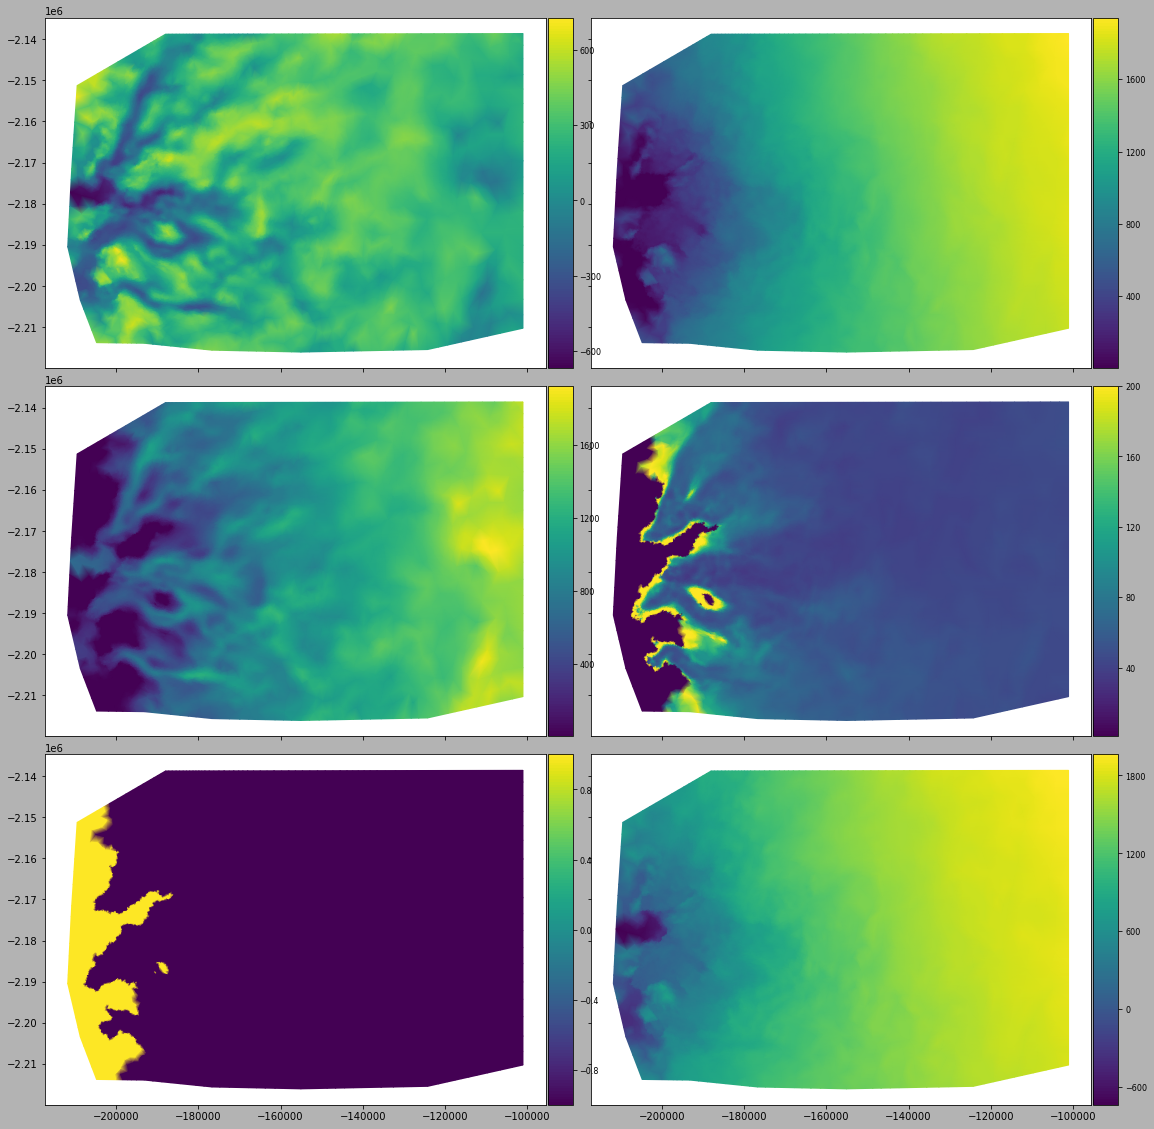

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))

plotmodel(md, 'data', md.geometry.bed, \
              'data', md.geometry.surface, \
              'data', md.geometry.thickness, \
              'data', md.friction.coefficient, \
              'data', md.mask.ice_levelset, \
              'data', md.mask.groundedice_levelset)
              #'data', md.initialization.vel, 'caxis#3', [0, 1000],

if False:
    from solve import solve
    md = solve(md, 'sb')

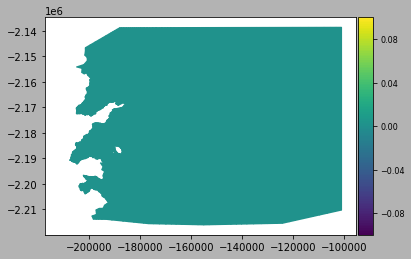

In [7]:
plotmodel(md, 'data', md.geometry.base - md.geometry.bed, 'mask', md.mask.ice_levelset<0)

In [8]:
# Step 3
## Inversion
#md = loadmodel('./Models/' +region+ '_Param.mat');
# Control general
md.inversion=m1qn3inversion(md.inversion);
md.inversion.iscontrol=1;
md.verbose.solution=False
md.verbose.control=True

# Cost functions
md.inversion.cost_functions=[101,103,501]; #Abs, Log, reg
md.inversion.cost_functions_coefficients=np.ones([md.mesh.numberofvertices,len(md.inversion.cost_functions)]);
md.inversion.cost_functions_coefficients[:,0]=2000;
md.inversion.cost_functions_coefficients[:,1]=40;
md.inversion.cost_functions_coefficients[:,2]=1.6e-06;

#Where vel==0, set coefficients to 0 (i.e., don't try to match this in model disp(['Removing vel==0 obs from inversion']);
#pos = find(md.inversion.vel_obs == 0);
#md.inversion.cost_functions_coefficients[pos,1] = 0;
#md.inversion.cost_functions_coefficients[pos,2] = 0;

#Controls
md.inversion.control_parameters=['FrictionCoefficient'];
md.inversion.maxsteps=50;
md.inversion.maxiter =50;
md.inversion.min_parameters=0.05*np.ones([md.mesh.numberofvertices,1]);
md.inversion.max_parameters=200*np.ones([md.mesh.numberofvertices,1]);
md.inversion.control_scaling_factors=1;

#Set basal friction coefficient initial guess to something low at front
filename = 'Exp/' +region+ '_coeffront.exp'
if os.path.isfile(filename):
  #disp(['Correcting basal friction coefficient initial guess for front inconsistencies']),
  flags = ContourToNodes(md.mesh.x,md.mesh.y,filename,2),
  #flags = md.inversion.vel_obs == 0;
  pos1 = np.where(flags)[0]
  #pos2 = np.where(~flags)[0]
  md.friction.coefficient[pos1] = 10

  md.inversion.max_parameters[pos1] = md.friction.coefficient[pos1]

#Additional parameters
md.stressbalance.restol=0.01;
md.stressbalance.reltol=0.1;
md.stressbalance.abstol=np.nan;
#md.stressbalance.requested_outputs={'default','DeviatoricStressxx','DeviatoricStressyy','DeviatoricStressxy'}

from solve import solve
md = solve(md,'Stressbalance')


converting inversion to m1qn3inversion
uploading input file and queueing script
launching solution sequence on remote cluster

Ice-sheet and Sea-level System Model (ISSM) version  4.21
(website: http://issm.jpl.nasa.gov contact: issm@jpl.nasa.gov)

call computational core:
   Initialize M1QN3 parameters
   Computing initial solution

Cost function f(x)   | Gradient norm |g(x)| |  List of contributions
____________________________________________________________________
f(x) =     284044.6  |             24.04802 |     943.4998     283081.4     19.77403
f(x) =     226100.2  |             1.738458 |     895.8694       225183     21.26019
f(x) =     225552.3  |             1.053364 |     873.8292       224657     21.39743
f(x) =     225228.7  |            0.4945095 |     846.8764     224360.3     21.55649
f(x) =     225032.4  |            0.3276761 |     825.2122     224185.5     21.61433
f(x) =     224897.7  |            0.2506441 |     794.7241     224081.3     21.67245
f(x) =     22478

In [9]:
md.mesh.elements = md.mesh.elements.astype(np.float64)
md.mesh.vertexonboundary = md.mesh.vertexonboundary.astype(np.float64)
md.mesh.edges = md.mesh.edges.astype(np.float64)
md.mesh.segments = md.mesh.segments.astype(np.float64)
md.mesh.segmentmarkers = md.mesh.segmentmarkers.astype(np.float64)
md.mesh.elementconnectivity = md.mesh.elementconnectivity.astype(np.float64)
md.mask.ice_levelset = md.mask.ice_levelset.astype(np.float64)
md.mask.ocean_levelset = md.mask.ocean_levelset.astype(np.float64)
md.basalforcings.groundedice_melting_rate = md.basalforcings.groundedice_melting_rate.astype(np.float64)
md.basalforcings.floatingice_melting_rate = md.basalforcings.floatingice_melting_rate.astype(np.float64)
md.materials.rheology_n = md.materials.rheology_n.astype(np.float64)
md.initialization.vz = md.initialization.vz.astype(np.float64)
md.stressbalance.loadingforce = md.stressbalance.loadingforce.astype(np.float64)

from export_netCDF import export_netCDF
export_netCDF(md, './Models/SAtoES_inversion.nc')

field md.solidearth.external is None
qmu is skipped until it is more stable
